## Synopsis ##
This submission for me was very back and forth, and now, while I am typing this at the very end, I am quite annoyed. Initially, I tried out a Randomforest, a KernelSVM and two different Logistic Regression models. Early on, I ended up wasting the Randomforest, because it took so long to find the right hyperparameters and it gave very bad results (we're talking .4/.5 on accuracy). Then, I heard today (the last day) that people around me had gotten even better scores than I (I eventually went for my 1st Logistic Regression variant) with the Randomforest, so I again decided to give it a try. I even looked at one of my sidekicks' hyperparameters to test. And then, after the mandatory 1.5 hrs. it takes to code such a sudden change, I got the astonishingly bafflingly superb accuracy of .62. WHAT THE HELL AM I DOING WRONG. I don't care anymore if this notebook is messy - I've done all I was supposed to, and I've struggled a lot for very mediocre results. Some hints and tricks on how to fucking do this right, would be awesome!

## Import necessary libraries ##

In [409]:
import math
import seaborn as sns
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

## Organising in dataframes & initial overview ##

Overview of headers, value types, NaN-values etc. Convertion from textual values to numerical.

In [410]:
# Usual organising in data frames and overview of column names
train = pd.read_csv("train.csv")
train_df = pd.DataFrame(train).drop(["Unnamed: 0", "index"], axis=1)

test = pd.read_csv("test.csv")
test_df = pd.DataFrame(test).drop(["Unnamed: 0", "index"], axis=1)

train_df.columns, test_df.columns

(Index(['AFP (ng/mL)', 'ALP (U/L)', 'ALT (U/L)', 'AST (U/L)', 'Age',
        'Albumin (g/dL)', 'Alcohol_Use (yes/no)', 'Bilirubin (mg/dL)',
        'CRP (mg/L)', 'Diabetes (yes/no)', 'Fibroscan (kPa)', 'GGT (U/L)',
        'Gender', 'Hemoglobin (g/dL)', 'IL-6 (pg/mL)', 'Obesity (yes/no)',
        'PT/INR', 'Platelets (10^9/L)', 'RBC (10^12/L)',
        'Serum_Ammonia (μmol/L)', 'Serum_Copper (μg/dL)',
        'Serum_Creatinine (mg/dL)', 'Serum_Iron (μg/dL)',
        'Serum_Lactate (mmol/L)', 'Serum_Urea (mg/dL)', 'Serum_Zinc (μg/dL)',
        'TIBC (μg/dL)', 'Transferrin_Saturation (%)', 'WBC (10^9/L)', 'pH',
        'Diagnosis'],
       dtype='object'),
 Index(['AFP (ng/mL)', 'ALP (U/L)', 'ALT (U/L)', 'AST (U/L)', 'Age',
        'Albumin (g/dL)', 'Alcohol_Use (yes/no)', 'Bilirubin (mg/dL)',
        'CRP (mg/L)', 'Diabetes (yes/no)', 'Fibroscan (kPa)', 'GGT (U/L)',
        'Gender', 'Hemoglobin (g/dL)', 'IL-6 (pg/mL)', 'Obesity (yes/no)',
        'PT/INR', 'Platelets (10^9/L)', 'RBC (1

In [411]:
# Handling of categorical data by mapping the values into binary. Mapping the 7 different diagnoses into numbers 0-6, so that I can create a
# correlation map.
mapping_yn = {"yes": 1, "no": 0}
mapping_gender = {"FEMALE": 1, "MALE": 0}
diagnoses = train_df["Diagnosis"].unique().tolist()
mapping_diagnosis = {diagnosis: diagnoses.index(diagnosis) for diagnosis in diagnoses}
columns_to_convert_train = ["Alcohol_Use (yes/no)", "Diabetes (yes/no)", "Gender", "Obesity (yes/no)", "Diagnosis"]
columns_to_convert_test = ["Alcohol_Use (yes/no)", "Diabetes (yes/no)", "Gender", "Obesity (yes/no)"]

train_df[columns_to_convert_train] = train_df[columns_to_convert_train].replace({**mapping_yn, **mapping_gender, **mapping_diagnosis})
test_df[columns_to_convert_test] = test_df[columns_to_convert_test].replace({**mapping_yn, **mapping_gender})

train_df["Diagnosis"]

C:\Users\kroel\AppData\Local\Temp\ipykernel_6640\1224009498.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df[columns_to_convert_train] = train_df[columns_to_convert_train].replace({**mapping_yn, **mapping_gender, **mapping_diagnosis})
C:\Users\kroel\AppData\Local\Temp\ipykernel_6640\1224009498.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_df[columns_to_convert_test] = test_df[columns_to_convert_test].replace({**mapping_yn, **mapping_gender})


0      0
1      1
2      0
3      2
4      0
      ..
698    4
699    1
700    4
701    0
702    4
Name: Diagnosis, Length: 703, dtype: int64

In [412]:
# Checking for NaN-values and finding there are none
train_df.isnull().sum(), test_df.isnull().sum()

(AFP (ng/mL)                   0
 ALP (U/L)                     0
 ALT (U/L)                     0
 AST (U/L)                     0
 Age                           0
 Albumin (g/dL)                0
 Alcohol_Use (yes/no)          0
 Bilirubin (mg/dL)             0
 CRP (mg/L)                    0
 Diabetes (yes/no)             0
 Fibroscan (kPa)               0
 GGT (U/L)                     0
 Gender                        0
 Hemoglobin (g/dL)             0
 IL-6 (pg/mL)                  0
 Obesity (yes/no)              0
 PT/INR                        0
 Platelets (10^9/L)            0
 RBC (10^12/L)                 0
 Serum_Ammonia (μmol/L)        0
 Serum_Copper (μg/dL)          0
 Serum_Creatinine (mg/dL)      0
 Serum_Iron (μg/dL)            0
 Serum_Lactate (mmol/L)        0
 Serum_Urea (mg/dL)            0
 Serum_Zinc (μg/dL)            0
 TIBC (μg/dL)                  0
 Transferrin_Saturation (%)    0
 WBC (10^9/L)                  0
 pH                            0
 Diagnosis

Outliers before: 23
Outliers before: 6
Outliers before: 1
Outliers before: 3
Outliers before: 0
Outliers before: 5
Outliers before: 0
Outliers before: 4
Outliers before: 11
Outliers before: 0
Outliers before: 12
Outliers before: 12
Outliers before: 0
Outliers before: 0
Outliers before: 9
Outliers before: 0
Outliers before: 1
Outliers before: 0
Outliers before: 15
Outliers before: 8
Outliers before: 7
Outliers before: 5
Outliers before: 0
Outliers before: 7
Outliers before: 9
Outliers before: 0
Outliers before: 2
Outliers before: 6
Outliers before: 18
Outliers before: 2
Outliers now: 12
Outliers now: 4
Outliers now: 0
Outliers now: 0
Outliers now: 0
Outliers now: 2
Outliers now: 0
Outliers now: 2
Outliers now: 11
Outliers now: 0
Outliers now: 8
Outliers now: 12
Outliers now: 0
Outliers now: 0
Outliers now: 15
Outliers now: 0
Outliers now: 0
Outliers now: 0
Outliers now: 10
Outliers now: 6
Outliers now: 5
Outliers now: 1
Outliers now: 0
Outliers now: 5
Outliers now: 1
Outliers now: 0
Out

(array([ 1.,  0.,  0.,  0.,  1.,  1.,  1.,  2.,  2.,  1.,  5.,  6.,  6.,
         7.,  9.,  6.,  7.,  9., 10., 14., 11., 13., 15.,  9., 16., 12.,
         7., 17., 15., 16., 12., 15., 18., 17.,  8., 16., 16., 10.,  9.,
        11.,  9., 12., 10., 12.,  7., 13.,  7.,  5.,  5.,  3.,  2.,  6.,
         7.,  5.,  2.,  3.,  4.,  7.,  4.,  5.,  2.,  2.,  4.,  5.,  1.,
         1.,  1.,  1.,  3.,  4.,  2.,  2.,  2.,  2.,  2.,  2.,  1.,  1.,
         2.,  1.,  0.,  1.,  1.,  2.,  2.,  0.,  0.,  0.,  0.,  3.,  0.,
         1.,  1.,  1.,  0.,  3.,  0.,  0.,  0.,  2.]),
 array([ 2.32352958,  2.48431817,  2.64510675,  2.80589533,  2.96668391,
         3.1274725 ,  3.28826108,  3.44904966,  3.60983825,  3.77062683,
         3.93141541,  4.092204  ,  4.25299258,  4.41378116,  4.57456974,
         4.73535833,  4.89614691,  5.05693549,  5.21772408,  5.37851266,
         5.53930124,  5.70008983,  5.86087841,  6.02166699,  6.18245557,
         6.34324416,  6.50403274,  6.66482132,  6.82560991,  6.986398

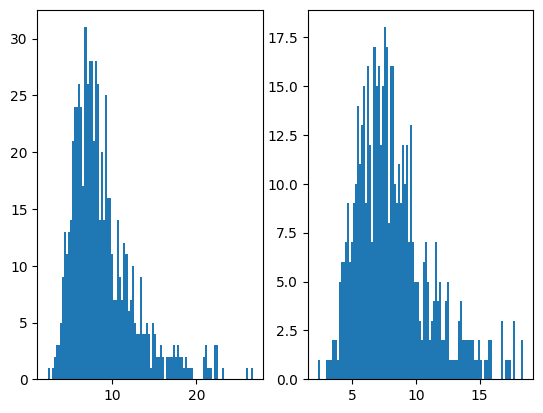

In [413]:
"""
trying to take care of outliers - I worked a while on this, although there still seems to be some outliers left. Plotting a random
category though, the distribution looks better after the handling. I chose to stop here, in fear of limiting the data too much. Any comments?
"""
fig, ax = plt.subplots(1, 2)
ax[0].hist(train_df['Fibroscan (kPa)'], bins=100)

for column in test_df.columns:
    z_score = (train_df[column] - np.mean(train_df[column])) / np.std(train_df[column])
    outliers = np.abs(z_score) > 3
    print(f'Outliers before: {np.sum(outliers)}')
    train_df = train_df[~outliers]

for column in test_df.columns:
    z_score = (train_df[column] - np.mean(train_df[column])) / np.std(train_df[column])
    outliers = np.abs(z_score) > 3
    print(f'Outliers now: {np.sum(outliers)}')

ax[1].hist(train_df['Fibroscan (kPa)'], bins=100)

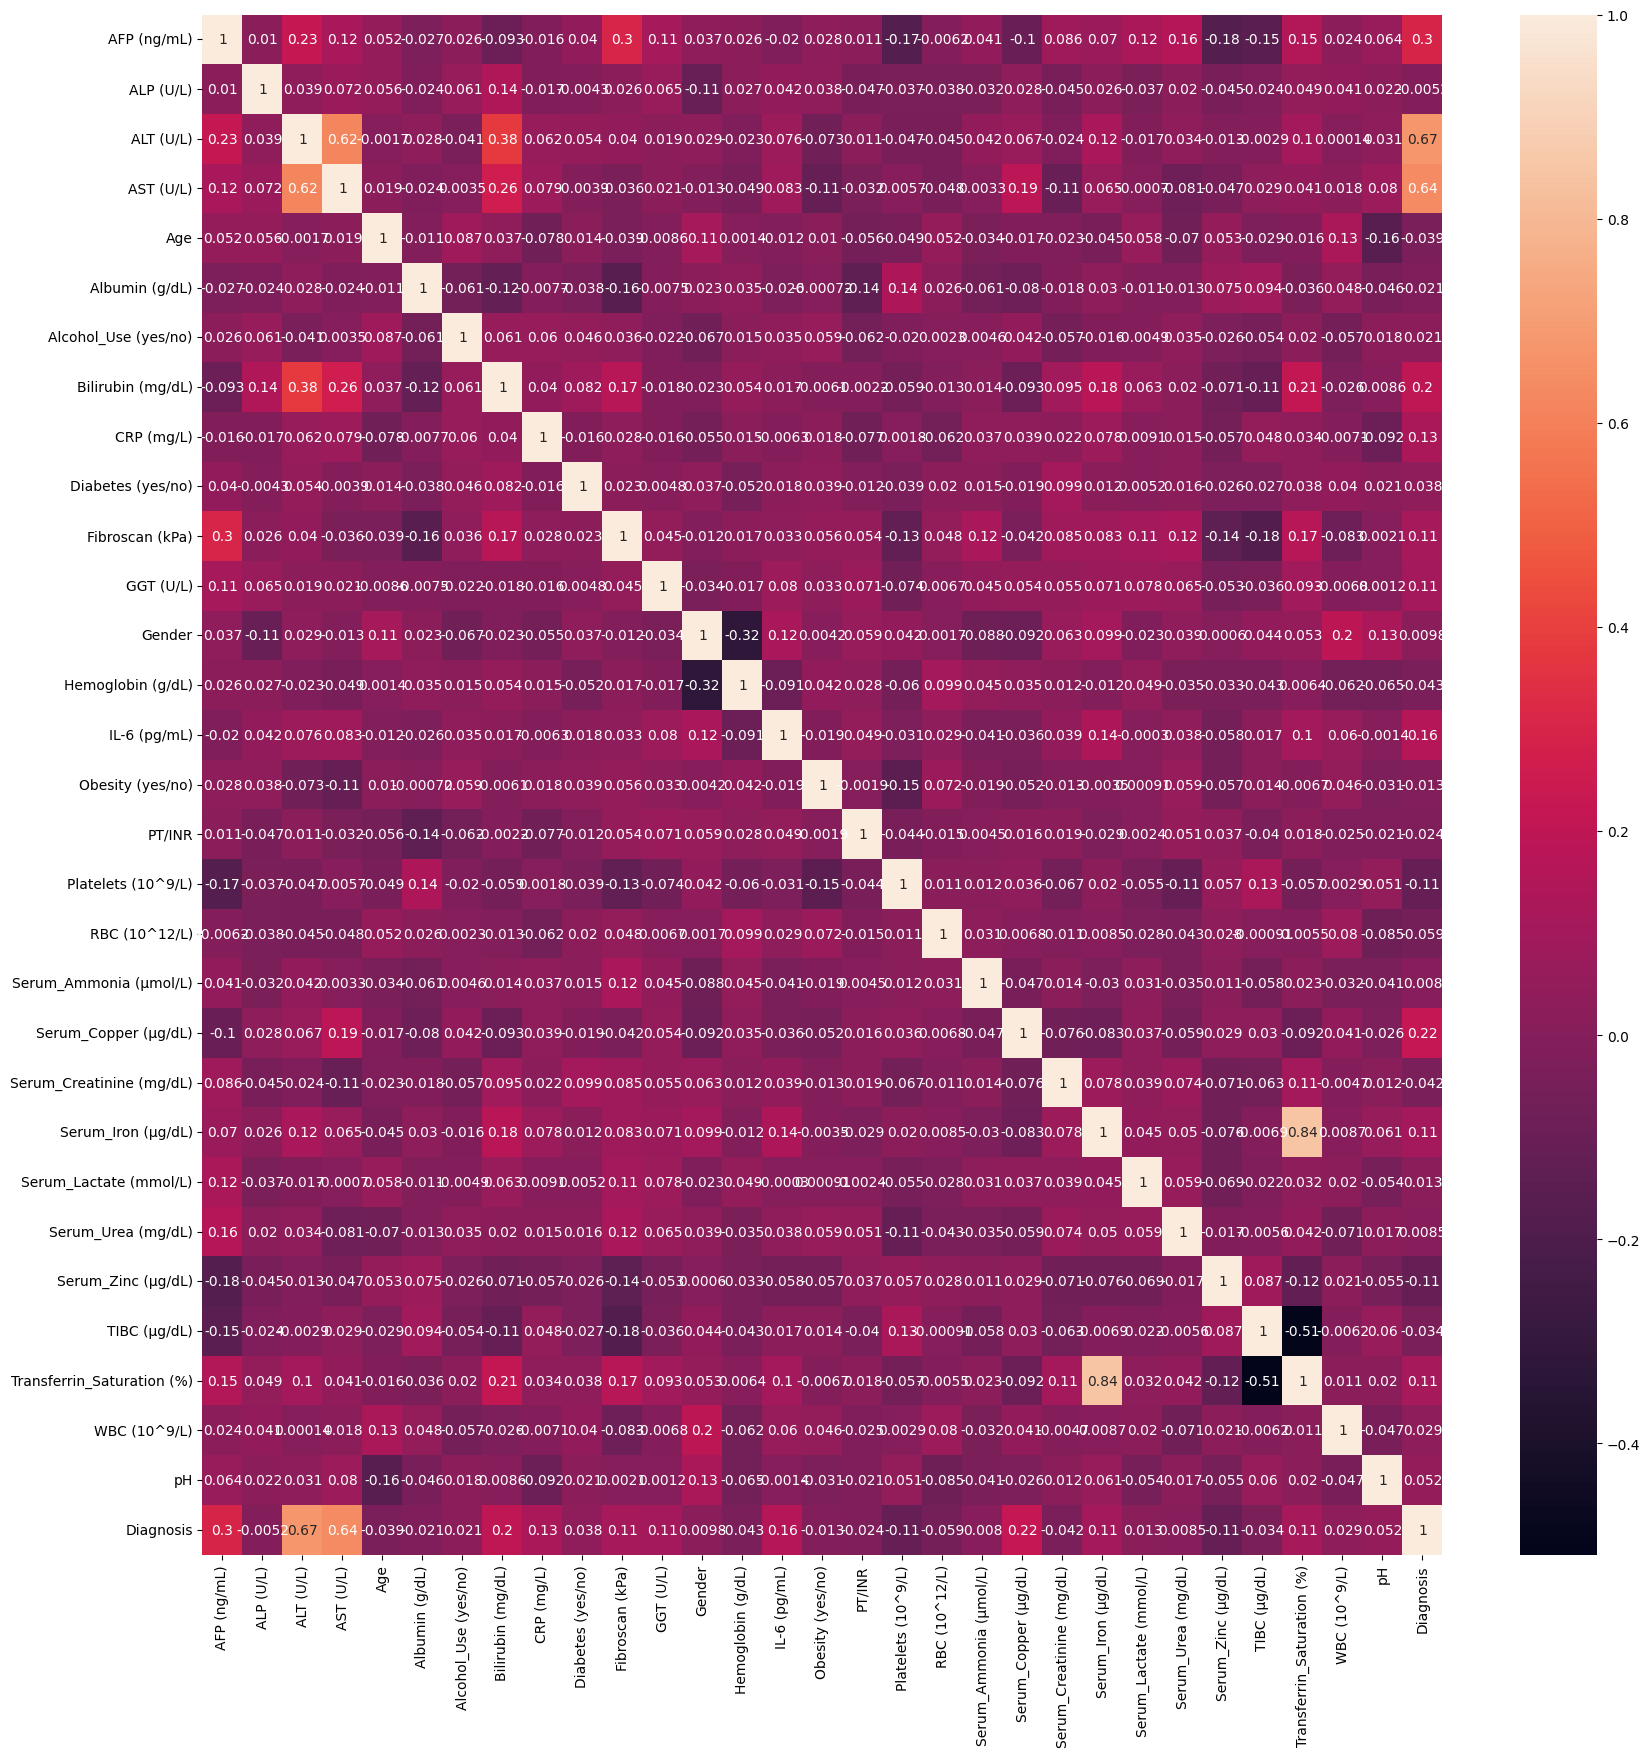

In [414]:
# Heatmap to check for linear correlation
plt.figure(figsize=(20, 20))
sns.heatmap(train_df.corr(), annot=True)
plt.show()

There is actually a significant linear correlation between ALT, AST and Diagnosis. This can suggest that a form for linear classification model actually can be rather helpful without an extensive use of computational power. Anyhow, I do PCA on all my model candidates except for the kNN, which normally does not benefit from dimensional reduction. kNN is just a go-to model of mine that I tend to try out every time, since it's so convenient.

<Axes: xlabel='ALT (U/L)', ylabel='AST (U/L)'>

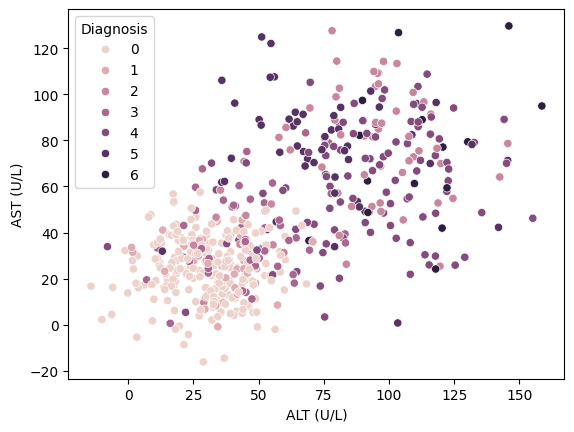

In [415]:
# To check the coherence between the most linearly correlating features and type of diagnosis, I plot a scatterplot.
sns.scatterplot(x=train_df['ALT (U/L)'], y=train_df['AST (U/L)'], hue=train_df['Diagnosis'])

The data seems somehow divided, but clearly not linearly separable. May be necessary with a kernel then.

### PCA ###
I chose PCA randomly, because I don't really know how to separate PCA from LDA in terms of what's best for this dataset:)

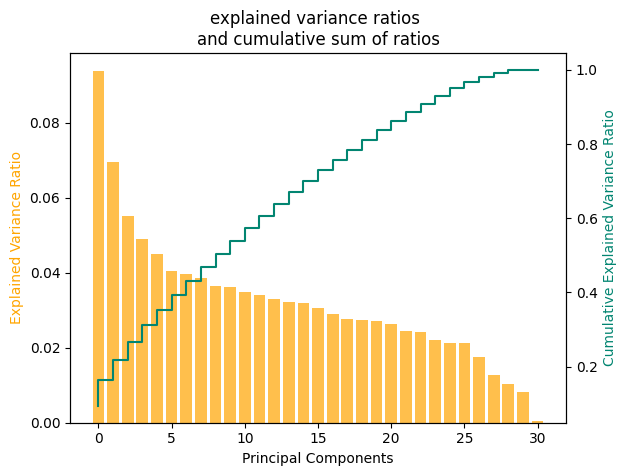

In [416]:
X_train_scaled = StandardScaler().fit_transform(train_df)

pca = PCA()
pca.fit_transform(X_train_scaled)

# Plot explained variance and cumulative sum of explained variance to get an impression of the importances of the different features
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.bar(np.arange(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_, alpha=0.7, color='orange')
ax2.step(np.arange(len(pca.explained_variance_ratio_)), np.cumsum(pca.explained_variance_ratio_), c='#028571')
ax1.set_xlabel('Principal Components')
ax1.set_ylabel('Explained Variance Ratio', color='orange')
ax2.set_ylabel('Cumulative Explained Variance Ratio', color='#028571')
plt.title('explained variance ratios \nand cumulative sum of ratios')
plt.show()

In [417]:
# train-test-split
y = train_df['Diagnosis'].values
X = train_df.drop('Diagnosis', axis=1).values
X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.3, random_state=42)

unique_values, value_counts = np.unique(y_train, return_counts=True)

# Print the unique values and their counts
for value, count in zip(unique_values, value_counts):
    print(f"{value}: {count}")

0: 158
1: 28
2: 41
3: 31
4: 69
5: 37
6: 11


## Pipelines ##

In [418]:
"""
I decided to shove the dataset with one-hot encoded categorical columns through the scalers of the pipelines, although this is not ideal. But this
should not be of any significance in this case, as we're only interested in the predictive results.
"""

rf = Pipeline([
     ('scaler', StandardScaler()),
     ('pca', PCA()),
     ('rf', RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42))
])

svm = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('svm', SVC(random_state=42))
])

knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

lgr = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('lgr', LogisticRegression(solver='liblinear', multi_class='ovr', class_weight='balanced', random_state=42))
])

# Thought I'd go for a logistic regression model using the softmax vector classification too, since we're dealing with multi class classification
# (I study NLT, language technology at UiO too, where we were introduced to the softmax):
lgr_soft = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('lgr', LogisticRegression(solver='lbfgs', multi_class='multinomial', class_weight='balanced', random_state=42))
])

# print(f"Randomforest parameters: {rf.get_params()}")
print(f"SVM parameters: {svm.get_params()}")
print(f"kNN parameters: {knn.get_params()}")
print(f"LogReg parameters: {lgr.get_params()}")

SVM parameters: {'memory': None, 'steps': [('scaler', StandardScaler()), ('pca', PCA()), ('svm', SVC(random_state=42))], 'verbose': False, 'scaler': StandardScaler(), 'pca': PCA(), 'svm': SVC(random_state=42), 'scaler__copy': True, 'scaler__with_mean': True, 'scaler__with_std': True, 'pca__copy': True, 'pca__iterated_power': 'auto', 'pca__n_components': None, 'pca__n_oversamples': 10, 'pca__power_iteration_normalizer': 'auto', 'pca__random_state': None, 'pca__svd_solver': 'auto', 'pca__tol': 0.0, 'pca__whiten': False, 'svm__C': 1.0, 'svm__break_ties': False, 'svm__cache_size': 200, 'svm__class_weight': None, 'svm__coef0': 0.0, 'svm__decision_function_shape': 'ovr', 'svm__degree': 3, 'svm__gamma': 'scale', 'svm__kernel': 'rbf', 'svm__max_iter': -1, 'svm__probability': False, 'svm__random_state': 42, 'svm__shrinking': True, 'svm__tol': 0.001, 'svm__verbose': False}
kNN parameters: {'memory': None, 'steps': [('scaler', StandardScaler()), ('knn', KNeighborsClassifier())], 'verbose': False,

## Hyperparameter testing ##

I originally chose to use randomised search for the KernelSVM and grid search for the rest. This is because the  For this code block, I took most inspiration from the lecture example notebook on grid search and random search, extracted the grid setups to kNN and LogReg (as they're not in the lecture example). I chose grid search because this got the best score in the example notebook - although I don't really know what the underlying factors are here...

In [419]:
n_estimators_range = [200, 300, 400]
depth_range = [5, 10, 15, 20]

neighbor_range = [7, 8, 9, 10, 11, 12, 15, 20]

n_components = [4, 5, 6, 7, 8, 9]

gamma_range = [0.001, 0.01, 0.1, 1.0, 10, 100]
C_range = [100, 500, 1000]
degrees = [1, 2, 3]

rf_grid = {'rf__n_estimators': n_estimators_range, 'rf__max_depth': depth_range}

knn_grid = {'knn__n_neighbors': neighbor_range}

svm_grid = [{'svm__C': C_range, 'svm__kernel': ['linear'], 'pca__n_components': n_components},
           {'svm__C': C_range, 'svm__kernel': ['rbf'], 'svm__gamma': gamma_range, 'pca__n_components': n_components}]

lgr_grid = {'lgr__C': gamma_range, 'lgr__penalty': ['l2'], 'pca__n_components': n_components}

In [420]:
# creating grid search objects for all respective model pipelines:
rf_search = GridSearchCV(estimator=rf, 
                           param_grid=rf_grid, 
                           scoring='f1_macro',
                           cv=10,
                           n_jobs=-1,
                            verbose=1)

knn_search = GridSearchCV(estimator=knn, 
                           param_grid=knn_grid, 
                           scoring='f1_macro', 
                           cv=10,
                           n_jobs=-1,
                           verbose=1)

svm_search = GridSearchCV(estimator=svm,
                            param_grid=svm_grid,
                            scoring='f1_macro',
                            cv=10,
                            n_jobs=-1,
                         verbose=2)

lgr_search = GridSearchCV(estimator=lgr, 
                           param_grid=lgr_grid, 
                           scoring='f1_macro', 
                           cv=10,
                           n_jobs=-1,
                           verbose=1)

lgr_soft_search = GridSearchCV(estimator=lgr_soft, 
                           param_grid=lgr_grid, 
                           scoring='f1_macro', 
                           cv=10,
                           n_jobs=-1,
                           verbose=1)

count = 0
for model in [rf_search, knn_search, svm_search, lgr_search, lgr_soft_search]:
    model_names = ['Randomforest', 'kNN', 'SVM', 'LogReg', 'LogRegSoftmax']
    model.fit(X_train, y_train)
    print(f'Best parameters for {model_names[count]}: {model.best_params_}')
    print(f'Best score for {model_names[count]}: {model.best_score_}')
    count += 1

Fitting 10 folds for each of 12 candidates, totalling 120 fits
Best parameters for Randomforest: {'rf__max_depth': 5, 'rf__n_estimators': 400}
Best score for Randomforest: 0.6287153111732943
Fitting 10 folds for each of 8 candidates, totalling 80 fits
Best parameters for kNN: {'knn__n_neighbors': 8}
Best score for kNN: 0.5354239678256114
Fitting 10 folds for each of 126 candidates, totalling 1260 fits
Best parameters for SVM: {'pca__n_components': 9, 'svm__C': 1000, 'svm__gamma': 0.001, 'svm__kernel': 'rbf'}
Best score for SVM: 0.5833277074138419
Fitting 10 folds for each of 36 candidates, totalling 360 fits
Best parameters for LogReg: {'lgr__C': 1.0, 'lgr__penalty': 'l2', 'pca__n_components': 9}
Best score for LogReg: 0.6238824492500964
Fitting 10 folds for each of 36 candidates, totalling 360 fits
Best parameters for LogRegSoftmax: {'lgr__C': 0.01, 'lgr__penalty': 'l2', 'pca__n_components': 9}
Best score for LogRegSoftmax: 0.6069835703299472


In [421]:
# Round 2 of search with the most successful models from previous search:
n_estimators_range2 = [500, 600, 700]
depth_range_2 = [3, 4, 6, 7]

components = [9, 10, 11, 12, 13]

gamma_range = [0.01, 0.1, 1.0, 10, 100, 1000]
C_range2 = [90, 100, 110]

rf_grid = {'rf__n_estimators': n_estimators_range, 'rf__max_depth': depth_range}

lgr_grid = {'lgr__C': gamma_range, 'lgr__penalty': ['l2'], 'pca__n_components': components}

svm_grid = {'svm__C': C_range, 'svm__kernel': ['rbf'], 'svm__gamma': gamma_range, 'pca__n_components': n_components}

rf_search = GridSearchCV(estimator=rf, 
                           param_grid=rf_grid, 
                           scoring='f1_macro',
                           cv=10,
                           n_jobs=-1,
                            verbose=1)

lgr_search = GridSearchCV(estimator=lgr_soft, 
                           param_grid=lgr_grid, 
                           scoring='f1_macro', 
                           cv=10,
                           n_jobs=-1,
                           verbose=1)

lgr_soft_search = GridSearchCV(estimator=lgr_soft, 
                           param_grid=lgr_grid, 
                           scoring='f1_macro', 
                           cv=10,
                           n_jobs=-1,
                           verbose=1)

count = 0
for model in [rf_search, lgr_search, lgr_soft_search]:
    model_names = ['Randomforest', 'LogReg', 'Softmax']
    model.fit(X_train, y_train)
    print(f'Best parameters for {model_names[count]}: {model.best_params_}')
    print(f'Best score for {model_names[count]}: {model.best_score_}')
    count += 1

Fitting 10 folds for each of 12 candidates, totalling 120 fits
Best parameters for Randomforest: {'rf__max_depth': 5, 'rf__n_estimators': 400}
Best score for Randomforest: 0.6287153111732943
Fitting 10 folds for each of 30 candidates, totalling 300 fits
Best parameters for LogReg: {'lgr__C': 0.01, 'lgr__penalty': 'l2', 'pca__n_components': 13}
Best score for LogReg: 0.6583849760115055
Fitting 10 folds for each of 30 candidates, totalling 300 fits
Best parameters for Softmax: {'lgr__C': 0.01, 'lgr__penalty': 'l2', 'pca__n_components': 13}
Best score for Softmax: 0.6583849760115055


## 10-fold cross-validation ##

In [422]:
# K-fold-algorithm was copied from the lecture example, before variables like 'SEED' were altered:
scores_rf = []
scores_svm = []
scores_lgr = []
scores_lgr_soft = []

skfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42).split(X_train, y_train)

rf_best = rf_search.best_estimator_
svm_best = svm_search.best_estimator_
lgr_best = lgr_search.best_estimator_
lgrs_best = lgr_soft_search.best_estimator_

for k, (train_idxs, validation_idxs) in enumerate(skfold):
    rf_best.fit(X_train[train_idxs], y_train[train_idxs])
    svm_best.fit(X_train[train_idxs], y_train[train_idxs])
    lgr_best.fit(X_train[train_idxs], y_train[train_idxs])
    lgrs_best.fit(X_train[train_idxs], y_train[train_idxs])

    y_pred_rf = rf_best.predict(X_train[validation_idxs])
    y_pred_svm = svm_best.predict(X_train[validation_idxs])
    y_pred_lgr = lgr_best.predict(X_train[validation_idxs])
    y_pred_lgrs = lgrs_best.predict(X_train[validation_idxs])

    rf_score = f1_score(y_train[validation_idxs], y_pred_rf, average='macro')
    svm_score = f1_score(y_train[validation_idxs], y_pred_svm, average='macro')
    lgr_score = f1_score(y_train[validation_idxs], y_pred_lgr, average='macro')
    lgrs_score = f1_score(y_train[validation_idxs], y_pred_lgrs, average='macro')

    scores_rf.append(rf_score)
    scores_svm.append(svm_score)
    scores_lgr.append(lgr_score)
    scores_lgr_soft.append(lgrs_score)
    
    print(f'Fold: {k+1:2d}, Class dist.: {np.bincount(y_train[train_idxs])}, RF-score: {rf_score:.3f}, SVM-score: {svm_score:.3f}, LogReg-score: {lgr_score:.3f}, Softmax-score: {lgrs_score:.3f}')

Fold:  1, Class dist.: [142  25  37  28  62  33  10], RF-score: 0.526, SVM-score: 0.431, LogReg-score: 0.674, Softmax-score: 0.674
Fold:  2, Class dist.: [142  25  37  28  62  33  10], RF-score: 0.672, SVM-score: 0.584, LogReg-score: 0.661, Softmax-score: 0.661
Fold:  3, Class dist.: [142  25  37  28  62  33  10], RF-score: 0.700, SVM-score: 0.765, LogReg-score: 0.686, Softmax-score: 0.686
Fold:  4, Class dist.: [142  25  37  28  62  33  10], RF-score: 0.678, SVM-score: 0.648, LogReg-score: 0.657, Softmax-score: 0.657
Fold:  5, Class dist.: [142  26  37  27  62  33  10], RF-score: 0.658, SVM-score: 0.623, LogReg-score: 0.614, Softmax-score: 0.614
Fold:  6, Class dist.: [142  26  36  28  63  34   9], RF-score: 0.322, SVM-score: 0.414, LogReg-score: 0.526, Softmax-score: 0.526
Fold:  7, Class dist.: [142  25  37  28  62  34  10], RF-score: 0.452, SVM-score: 0.646, LogReg-score: 0.693, Softmax-score: 0.693
Fold:  8, Class dist.: [142  25  37  28  62  34  10], RF-score: 0.545, SVM-score: 0

In [423]:
print(f'Average RF-score: {np.mean(scores_rf):.3f} +/- {np.std(scores_rf):.3f}')
print(f'Average SVM-score: {np.mean(scores_svm):.3f} +/- {np.std(scores_svm):.3f}')
print(f'Average LogReg-score: {np.mean(scores_lgr):.3f} +/- {np.std(scores_lgr):.3f}')
print(f'Average Softmax-score: {np.mean(scores_lgr_soft):.3f} +/- {np.std(scores_lgr_soft):.3f}')

Average RF-score: 0.605 +/- 0.133
Average SVM-score: 0.599 +/- 0.113
Average LogReg-score: 0.650 +/- 0.057
Average Softmax-score: 0.650 +/- 0.057


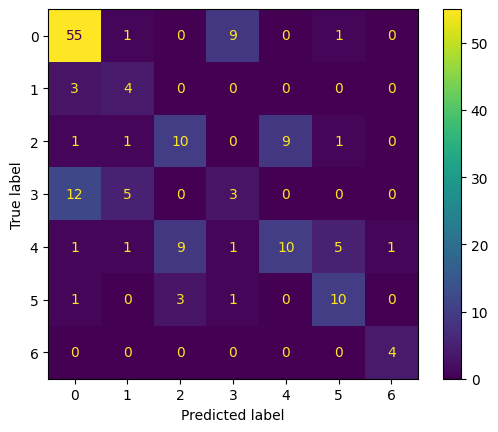

In [424]:
# Confusion matrix for LogReg-model, the best one after tests:
y_pred_lgr = lgr_best.predict(X_dev)
ConfusionMatrixDisplay.from_predictions(y_dev, y_pred_lgr)
plt.show()

### Comments on confusion matrix ###
The confusion matrix shows an ok concentration of correct predictions (on the top-left - bottom-right - diagonal), which is a good sign. This is an indicator of sufficient correct predictions. Although, there are some deviations - the model often confuses 0 and 3, and 2 and 4. Most important though, is to note that the model doesn't predict only 'healthy'. In a case of illness prediction like this one, it is key that the model does not tend to predict healthiness in cases of disease, even if this makes the model less accurate overall. It does predict 'healthy' in cases of disease number 3, but it is not extremely often. Something to be careful of though.

## Kaggle submission ##

In [425]:
"""
Kaggle upload; I train all three suitable models on the whole training set from before. The LogReg turned out to be the best model,
but I just make files for the other two as well, to be able to upload their results too.
"""

rf_best.fit(X, y)
svm_best.fit(X, y)
lgr_best.fit(X, y)

X_test = test_df.values

model_name_list = ["Randomforest", "SVM", "LogReg"]
count = 0
for model in [rf_best, svm_best, lgr_best]:
    y_pred = model.predict(X_test)
    # Using the previous 'diagnoses'-list (train_df['Diagnosis'].unique.tolist())
    y_pred = [diagnoses[entry] for entry in y_pred]

    submission_df = pd.DataFrame(y_pred, columns=['Diagnosis'])
    submission_df.to_csv(f'{model_name_list[count]}.csv', index_label='index')
    count += 1


## Binary classifcation approach ##

In [426]:
y_train[(y_train >= 2) & (y_train <= 7)] = 1
y_dev[(y_dev >= 2) & (y_dev <= 7)] = 1
np.unique(y_train), np.unique(y_dev)

(array([0, 1], dtype=int64), array([0, 1], dtype=int64))

In [427]:
# Ratio of '1'-entries and '0'-entries. Almost half of data is of healthy patients!
y_train.sum(), len(y_train)

(217, 375)

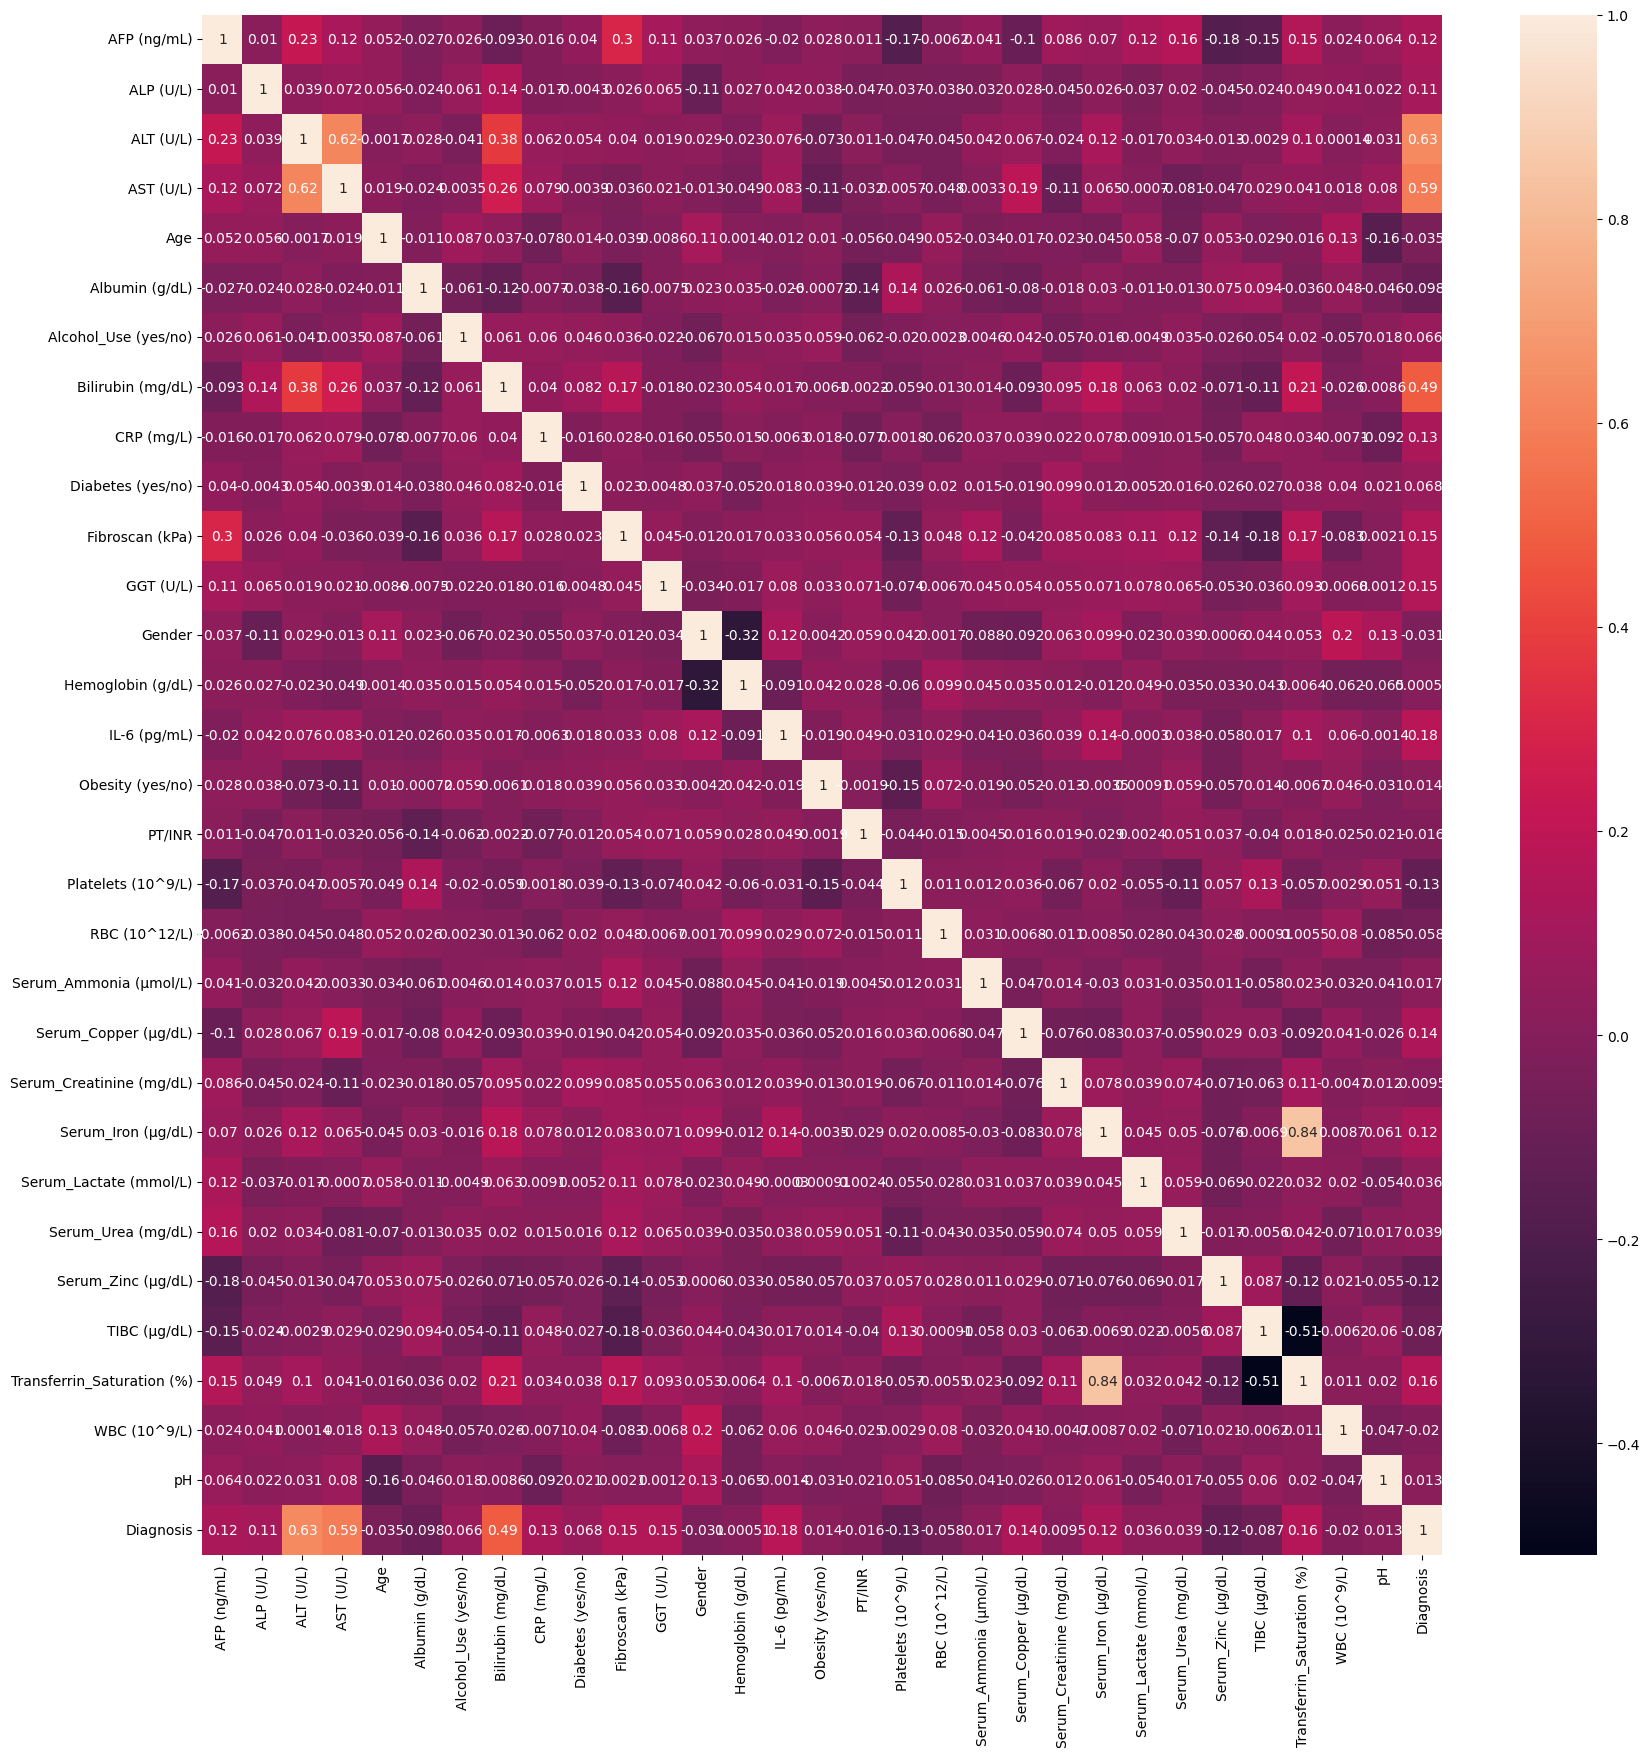

<Axes: xlabel='AST (U/L)', ylabel='Bilirubin (mg/dL)'>

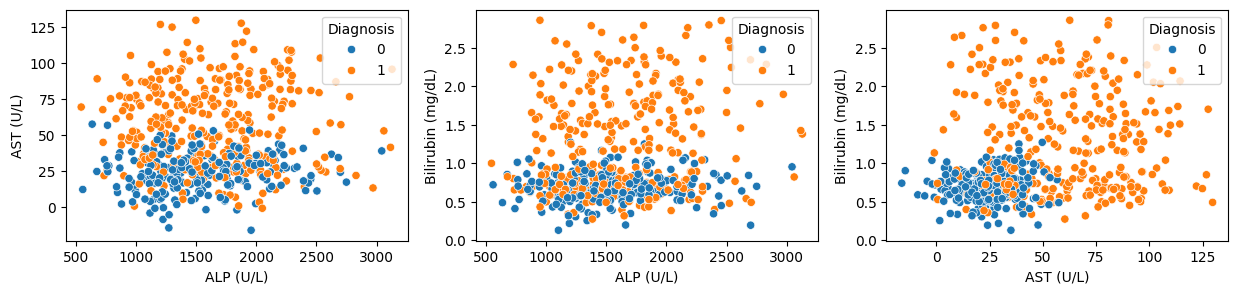

In [428]:
"""
Making correlation map and scatterplot for binary model too. Then I first need to convert the 'Diagnosis'-column in the original dataframe
to binary values, so that I can plot the dataframe. Man, this assignment really was a workload!
"""

train_df['Diagnosis'] = np.where(train_df['Diagnosis'] != 0, 1, train_df['Diagnosis'])

plt.figure(figsize=(20, 20))
sns.heatmap(train_df.corr(), annot=True)
plt.show()

fig, ax = plt.subplots(1, 3, figsize=(15, 3))
sns.scatterplot(x=train_df['ALP (U/L)'], y=train_df['AST (U/L)'], hue=train_df['Diagnosis'], ax=ax[0])
sns.scatterplot(x=train_df['ALP (U/L)'], y=train_df['Bilirubin (mg/dL)'], hue=train_df['Diagnosis'], ax=ax[1])
sns.scatterplot(x=train_df['AST (U/L)'], y=train_df['Bilirubin (mg/dL)'], hue=train_df['Diagnosis'], ax=ax[2])

In [429]:
# Just went for the logistic Regression model I had from before (honestly, I don't have the time to train new pipelines all day)
lgr_search.fit(X_train, y_train)
print(f'Best parameters: {lgr_search.best_params_}')
print(f'Best score: {lgr_search.best_score_}')

lgr_best = lgr_search.best_estimator_


Fitting 10 folds for each of 30 candidates, totalling 300 fits
Best parameters: {'lgr__C': 0.1, 'lgr__penalty': 'l2', 'pca__n_components': 9}
Best score: 0.9164244791466409


### ROC-curve ###

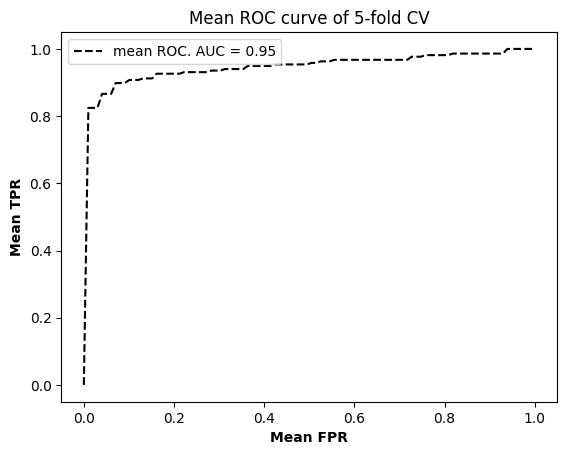

In [430]:
"""
This was mostly copy-paste from the example notebook from the lecture. I had a hard time getting to understand the lot - the
code is very difficult to understand. But I managed to illuminate myself; the only thing I'm not quite sure about now is the threshold-
values and what they mean.
"""

skfold = list(StratifiedKFold(n_splits=5, shuffle=True, random_state=42).split(X_train, y_train))

mean_tpr = 0
mean_fpr = np.linspace(0, 1, 100)

for train_idxs, validation_idxs in skfold:
    
    lgr_best.fit(X_train[train_idxs], y_train[train_idxs])
    
    probas = lgr_best.predict_proba(X_train[validation_idxs])

    fpr, tpr, threshold = roc_curve(y_train[validation_idxs], probas[:, 1], pos_label=1)
    mean_tpr += np.interp(mean_fpr, fpr, tpr)

# Mean TPR
mean_tpr /= 5
mean_tpr[0] = 0
mean_tpr[-1] = 1.0
# mean AUC
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, 'k--', label=f"mean ROC. AUC = {mean_auc:.2f}")
plt.legend()
plt.xlabel("Mean FPR", fontweight='bold')
plt.ylabel("Mean TPR", fontweight='bold')
plt.title("Mean ROC curve of 5-fold CV")
plt.show()